* <font color="red">assignment problem</font>. The red color indicates the task that should be done
* <font color="green">debugging</font>. The green tells you what is expected outcome. Its primarily goal is to help you get the correct answer
* <font color="blue">comments, hints</font>.

Assignment 3 (CNN)
======================


**Useful References:**
* official pytorch cifar10 tutorial


https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* tensorboard in colab


https://www.tensorflow.org/tensorboard/r2/tensorboard_in_notebooks
* tensorboard & colab


https://colab.research.google.com/drive/1NbEqqB42VSzYt-mmb4ESc8yxL05U2TIV


https://medium.com/looka-engineering/how-to-use-tensorboard-with-pytorch-in-google-colab-1f76a938bc34



## Preliminaries


#### Check the environment

In [0]:
!pwd

/content


In [0]:
!nvidia-smi

Wed Aug  7 21:18:34 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#### Install missing packages

In [0]:
# [colab version] latest version of tensorflow in order to use tensorboard inside the notebook
!pip install -q tf-nightly-2.0-preview
! pip install future

     |████████████████████████████████| 86.4MB 89.4MB/s 
     |████████████████████████████████| 61kB 28.2MB/s 
     |████████████████████████████████| 450kB 52.0MB/s 
     |████████████████████████████████| 4.3MB 53.4MB/s 


#### Load libs, set settings

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import datetime

import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

# for tensorboard
from torch.utils.tensorboard import SummaryWriter

In [0]:
# random seed settings
torch.manual_seed(42)
np.random.seed(42)

In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# for auto-reloading external modules (files, etc.)
%load_ext autoreload
%autoreload 2

# to be able to make plots inline the notebook 
# (actually no need for the colab version)
%matplotlib inline

# make plots a bit nicer
plt.matplotlib.rcParams.update({'font.size': 18, 'font.family': 'serif'})

## Define pathes

In [0]:
# path for dataset (will be not there after end of session)
path_data = "./data"

## Define device

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Data

Using ``torchvision`` load CIFAR10.

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=path_data, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root=path_data, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

100%|█████████▉| 170426368/170498071 [00:14<00:00, 12914972.19it/s]

Files already downloaded and verified


In [0]:
ls data

cifar-10-batches-py/  cifar-10-python.tar.gz


Let us show some of the training images, for fun.



 ship  ship  bird horse


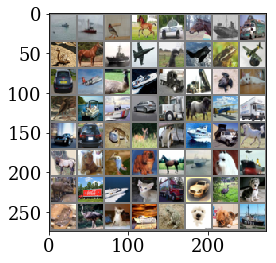

In [0]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
images, labels = next(iter(trainloader))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define a Convolution Neural Network

Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

170500096it [00:30, 12914972.19it/s]                               

## Define a Loss function

Let's use a Classification Cross-Entropy loss



In [0]:
criterion = nn.CrossEntropyLoss()

## Set-up training




In [0]:
def train_epoch(train_loader, model, criterion, optimizer, scheduler, 
                epoch, device, log_interval, globaliter):

    # switch to train mode
    model.train()
    
    # adjust_learning_rate
    if scheduler is not None:
        scheduler.step()

    for batch_idx, (input_data, target) in enumerate(train_loader):
      
        # TODO: do in other way (this is global batch index, for logging)
        globaliter += 1
      
        # extract batch data
        target = target.to(device)
        input_data = input_data.to(device)

        # compute output
        output = model(input_data)
        loss = criterion(output, target)
        
        # compute gradient and do optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # logging
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                      epoch, batch_idx * len(input_data), len(train_loader.dataset),
                      100. * batch_idx / len(train_loader), loss.item()))
        
            # log loss
            writer.add_scalar('Train/RunningLoss', loss.item(), globaliter)
            # log LR
            lr = scheduler.get_lr()[0]
            writer.add_scalar('Train/LearningRate', lr, globaliter)
    
    return globaliter

## Logging

In [0]:
# path for dataset (will be not there after end of session)
current_time = str(datetime.datetime.now().timestamp())
path_log = 'logs/tensorboard/' + current_time

# set-up writer
writer = SummaryWriter(path_log)

In [0]:
# Model (and Images) to TensorBoard (TB)

images, labels = next(iter(trainloader))
grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)

# net to TB
writer.add_graph(net, images.to(device))

In [0]:
%tensorboard --logdir logs/tensorboard

UsageError: Line magic function `%tensorboard` not found.


## Training

In [0]:
def get_statistics(dataloader, model, device):
    model = model.to(device)
    model.eval()
    
    correct = 0
    losses = []
    
    for batch_idx, (input_data, target) in enumerate(dataloader):

        # extract batch data
        target = target.to(device)
        input_data = input_data.to(device)

        # compute output
        output = model(input_data)
        output_klasses = torch.argmax(output, 1)
        correct += torch.sum(output_klasses == target).item()
        
        loss = criterion(output, target)
        losses.append(loss.item())    

    accuracy = correct / len(dataloader.dataset)
    mean_loss = np.mean(losses)
    
    return mean_loss, accuracy

In [0]:
# set number of epoch
net = Net().to(device)

n_epochs = 10

# set-up optimizer and scheduler
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=5,
                                            gamma=0.1)

globaliter = 0
for epoch in range(1, n_epochs + 1):
    globaliter = train_epoch(trainloader, net, criterion, optimizer, scheduler, epoch, device, 500, globaliter)
    
    # Calculate loss and accuracy after epoch
    loss, accuracy = get_statistics(trainloader, net, device) 
    test_loss, test_accuracy = get_statistics(testloader, net, device)
    
    # Log results
    writer.add_scalar('Train/LossEpoch', loss, epoch)
    writer.add_scalar('Train/AccuracyEpoch', accuracy, epoch)
    writer.add_scalar('Test/AccuracyEpoch', test_accuracy, epoch)
    
    print(f'test loss: {test_loss}, train loss: {loss},  test accuracy: {test_accuracy}, train accuracy: {accuracy}')


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.301511
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.291866
test loss: 2.282027783667206, train loss: 2.2828221055857667,  test accuracy: 0.1931, train accuracy: 0.18936
Train Epoch: 2 [0/50000 (0%)]	Loss: 2.285277
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.086860
test loss: 1.9959218995586323, train loss: 2.0073998070433925,  test accuracy: 0.2799, train accuracy: 0.27476
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.956559
Train Epoch: 3 [32000/50000 (64%)]	Loss: 2.038932
test loss: 1.8015908822891817, train loss: 1.8130262843178362,  test accuracy: 0.3526, train accuracy: 0.3446
Train Epoch: 4 [0/50000 (0%)]	Loss: 1.850686
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.628139
test loss: 1.6724947652999003, train loss: 1.680901264138234,  test accuracy: 0.3859, train accuracy: 0.38208
Train Epoch: 5 [0/50000 (0%)]	Loss: 1.922233
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.482241
test loss: 1.6186742949637638, train loss: 1.625848905509695,  test accuracy: 0.4058

In [0]:
ls logs/tensorboard/

1565212777.174552/


##  Test the network on the test data





In [0]:
# switch to test mode
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

GroundTruth:    cat  ship  ship plane


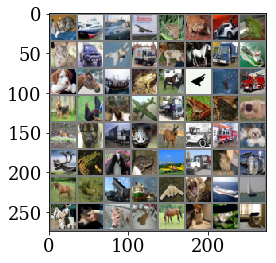

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   frog  ship  ship plane




Let us look at how the network performs on the whole dataset.



In [0]:
def log_accuracy(model):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))
  
log_accuracy(net)

Accuracy of the network on the 10000 test images: 42 %


the classes that performed well, and the classes that did
not perform well:



In [0]:
def log_klasses_accuracy(model):
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          c = (predicted == labels).squeeze()
          for i in range(4):
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1


  for i in range(10):
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))
      
log_klasses_accuracy(net) 

Accuracy of plane : 58 %
Accuracy of   car : 62 %
Accuracy of  bird : 22 %
Accuracy of   cat : 15 %
Accuracy of  deer : 18 %
Accuracy of   dog : 47 %
Accuracy of  frog : 55 %
Accuracy of horse : 51 %
Accuracy of  ship : 51 %
Accuracy of truck : 44 %


## Tasks

### <font color="red"> **MORE Tensorboard**: </font>   
- create separate plots with 'epoch vs. loss' (in addition to the current 'interation vs. loss')
- create separate plots with 'epoch vs. accuracy(train)' 
- create separate plots with 'epoch vs. accuracy(test)'
(for this create separate tag 'Test')

### <font color="red"> **IMPROVE THE MODEL**: </font>   

Experiment and try to get the best performance that you can on CIFAR-10 using a ConvNet. Here are some ideas to get you started:
(tips based on 'cs231n course')

#### Things to try:
- Filter size
- Number of filters
- Batch normalization
- Network architecture. Some good architectures to try include:
    - [conv-relu-pool]xN - conv - relu - [FC]xM 
    - [conv-relu-pool]XN - [FC]XM 
    - [conv-relu-conv-relu-pool]xN - [FC]xM 

#### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the course-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.

#### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. 

- Alternative update steps:  SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, or MaxOut.
- Model ensembles
- Data augmentation


#### What to expect
At the very least, you should be able to train a ConvNet that gets at least 65% accuracy on the validation set. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! 


###  <font color="red"> **CPU vs GPU**: </font>   
compare time of training for CPU, GPU for different models



In [0]:
%%timeit -n 1 -r 1
device = torch.device('cpu')
net = Net().to(device)

# set number of epoch
n_epochs = 10

# set-up optimizer and scheduler
optimizer = torch.optim.SGD(net.parameters(), lr=0.01,  momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)

globaliter = 0
for epoch in range(1, n_epochs + 1):
    globaliter = train_epoch(trainloader, net, criterion, optimizer, scheduler, epoch, device, 500, globaliter)
    

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.304645
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.819143
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.583003
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.304092
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.194011
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.130684
Train Epoch: 4 [0/50000 (0%)]	Loss: 1.493921
Train Epoch: 4 [32000/50000 (64%)]	Loss: 0.944348
Train Epoch: 5 [0/50000 (0%)]	Loss: 1.437835
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.008037
Train Epoch: 6 [0/50000 (0%)]	Loss: 1.082876
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.070548
Train Epoch: 7 [0/50000 (0%)]	Loss: 0.978809
Train Epoch: 7 [32000/50000 (64%)]	Loss: 1.133393
Train Epoch: 8 [0/50000 (0%)]	Loss: 1.276786
Train Epoch: 8 [32000/50000 (64%)]	Loss: 0.883486
Train Epoch: 9 [0/50000 (0%)]	Loss: 1.227064
Train Epoch: 9 [32000/50000 (64%)]	Loss: 0.914080
Train Epoch: 10 [0/50000 (0%)]	Loss: 1.081990
Train Epoch: 10 [32000/50000 (64%)]	Loss: 1.125034
1 loop, best of 1: 2min 32s per loop


In [0]:
%%timeit -n 1 -r 1
device = torch.device('cuda')
net = Net().to(device)

# set number of epoch
n_epochs = 10

# set-up optimizer and scheduler
optimizer = torch.optim.SGD(net.parameters(), lr=0.01,  momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)

globaliter = 0
for epoch in range(1, n_epochs + 1):
    globaliter = train_epoch(trainloader, net, criterion, optimizer, scheduler, epoch, device, 500, globaliter)
    

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.299126
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.800677
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.631932
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.269078
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.544789
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.282754
Train Epoch: 4 [0/50000 (0%)]	Loss: 1.252945
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.449674
Train Epoch: 5 [0/50000 (0%)]	Loss: 1.140523
Train Epoch: 5 [32000/50000 (64%)]	Loss: 0.964252
Train Epoch: 6 [0/50000 (0%)]	Loss: 1.316677
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.150061
Train Epoch: 7 [0/50000 (0%)]	Loss: 1.046501
Train Epoch: 7 [32000/50000 (64%)]	Loss: 0.913443
Train Epoch: 8 [0/50000 (0%)]	Loss: 1.077479
Train Epoch: 8 [32000/50000 (64%)]	Loss: 0.938301
Train Epoch: 9 [0/50000 (0%)]	Loss: 0.835216
Train Epoch: 9 [32000/50000 (64%)]	Loss: 1.272383
Train Epoch: 10 [0/50000 (0%)]	Loss: 0.902949
Train Epoch: 10 [32000/50000 (64%)]	Loss: 1.057725
1 loop, best of 1: 1min 25s per loop


### For this very small network we can see 2x speed boost when using gpu.

## Baseline  accuracy: 0.42 at epoch 10. Let's make some experiments to get higher accuracy.



## Experiment 1: Change network architecture, number of filters, add batch normalization and softmax *activation*

In [0]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(64)
        
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.batch_norm4 = nn.BatchNorm2d(128)
        self.batch_norm5 = nn.BatchNorm2d(128)
        self.batch_norm6 = nn.BatchNorm1d(512)

        
        self.conv1 = nn.Conv2d(3, 64, 3)       
        self.conv2 = nn.Conv2d(64, 64, 3)
        
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 128, 3)
        self.conv5 = nn.Conv2d(128, 128, 3)

        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)

        
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        
        x = self.conv4(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        
        x = self.conv5(x)
        x = self.batch_norm5(x)
        x = F.relu(x)

        x = self.pool(x)

        x = x.view(-1, 128 * 4 * 4)
        x = self.fc1(x)
        x = self.batch_norm6(x)
        x = F.relu(x)

        x = F.softmax(self.fc2(x), dim=1)
        return x


net = Net2().to(device)

In [0]:
# set number of epoch
n_epochs = 10

# set-up optimizer and scheduler
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

globaliter = 0
for epoch in range(1, n_epochs + 1):
    globaliter = train_epoch(trainloader, net, criterion, optimizer, scheduler, epoch, device, 500, globaliter)
    
    # Calculate loss and accuracy after epoch
    loss, accuracy = get_statistics(trainloader, net, device) 
    test_loss, test_accuracy = get_statistics(testloader, net, device)
    
    # Log results
    print(f'test loss: {test_loss}, train loss: {loss},  test accuracy: {test_accuracy}, train accuracy: {accuracy}')


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.302632
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.198828
test loss: 2.1059519705499055, train loss: 2.105813228108389,  test accuracy: 0.3807, train accuracy: 0.37886
Train Epoch: 2 [0/50000 (0%)]	Loss: 2.112392
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.927741
test loss: 2.008093098166642, train loss: 2.005148159268567,  test accuracy: 0.489, train accuracy: 0.48788
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.997410
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.933708
test loss: 1.933888166573397, train loss: 1.9257085442238147,  test accuracy: 0.5531, train accuracy: 0.56094
Train Epoch: 4 [0/50000 (0%)]	Loss: 1.952847
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.803449
test loss: 1.8921644634501948, train loss: 1.8796991292777878,  test accuracy: 0.5898, train accuracy: 0.60422
Train Epoch: 5 [0/50000 (0%)]	Loss: 1.834022
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.960070
test loss: 1.872780329862218, train loss: 1.8556912689257765,  test accuracy: 0.6111, 

In [0]:
log_accuracy(net)
log_klasses_accuracy(net) 

Accuracy of the network on the 10000 test images: 62 %
Accuracy of plane : 76 %
Accuracy of   car : 88 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer : 54 %
Accuracy of   dog : 79 %
Accuracy of  frog : 82 %
Accuracy of horse : 75 %
Accuracy of  ship : 82 %
Accuracy of truck : 80 %


## Received accuracy: 0.62

## Experiment 2: Change learning rate, learning rate decay, momentum and optimizer

In [0]:
# set number of epoch
net = Net2().to(device)
n_epochs = 10

# set-up optimizer and scheduler
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)

globaliter = 0
for epoch in range(1, n_epochs + 1):
    globaliter = train_epoch(trainloader, net, criterion, optimizer, scheduler, epoch, device, 200, globaliter)
    
    # Calculate loss and accuracy after epoch
    loss, accuracy = get_statistics(trainloader, net, device) 
    test_loss, test_accuracy = get_statistics(testloader, net, device)
    
    # Log results
    print(f'test loss: {test_loss}, train loss: {loss},  test accuracy: {test_accuracy}, train accuracy: {accuracy}')


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.306278
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.048320
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.092875
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.921473
test loss: 1.882787701430594, train loss: 1.8726124594278653,  test accuracy: 0.5792, train accuracy: 0.58928
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.824288
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.846037
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.826981
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.802477
test loss: 1.7886292357353648, train loss: 1.7692360989273053,  test accuracy: 0.675, train accuracy: 0.6951
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.816590
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.698074
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.785017
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.786597
test loss: 1.7396014435276104, train loss: 1.7166016618614002,  test accuracy: 0.7252, train accuracy: 0.75024
Train Epoch: 4 [0/50000 (0%)]	Loss: 1.693295
Train Epoch: 4 [12800/50000 (26%)]	Loss:

In [0]:
log_accuracy(net)
log_klasses_accuracy(net) 

## Received accuracy: 0.79


## Experiment 3: Data augmentation


In [0]:
# Took constants from https://github.com/kuangliu/pytorch-cifar/issues/19
NORMALIZATION_MEAN, NORMALIZATION_STD = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

train_transform = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD),
])


trainset = torchvision.datasets.CIFAR10(root=path_data, train=True, download=False, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)


testset = torchvision.datasets.CIFAR10(root=path_data, train=False, download=False, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=4)



In [0]:

# set number of epoch
net = Net2().to(device)
n_epochs = 10

# set-up optimizer and scheduler
optimizer = torch.optim.SGD(net.parameters(), lr=0.1,  momentum=0.8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)

globaliter = 0
for epoch in range(1, n_epochs + 1):
    globaliter = train_epoch(trainloader, net, criterion, optimizer, scheduler, epoch, device, 200, globaliter)
    
    # Calculate loss and accuracy after epoch
    loss, accuracy = get_statistics(trainloader, net, device) 
    test_loss, test_accuracy = get_statistics(testloader, net, device)
    
    # Log results
    print(f'test loss: {test_loss}, train loss: {loss},  test accuracy: {test_accuracy}, train accuracy: {accuracy}')


In [0]:
log_accuracy(net)
log_klasses_accuracy(net) 

## Received accuracy: 0.8  (Model still struggles to learn cats )

## Experiment 4: Use pretrained network

In [0]:
class ResNet18(nn.Module):
    '''
    Last fully connected layer changed to ouput EMBEDDINGS_SIZE-dim vector.
    '''
    
    def __init__(self):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(in_features=512, out_features=10, bias=True)

    def forward(self, image):
        features = self.model(image)
        return features


net = ResNet18().to(device)

In [0]:
# set number of epoch
n_epochs = 10

# set-up optimizer and scheduler
optimizer = torch.optim.SGD(net.parameters(), lr=0.01,  momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)

globaliter = 0
for epoch in range(1, n_epochs + 1):
    globaliter = train_epoch(trainloader, net, criterion, optimizer, scheduler, epoch, device, 200, globaliter)
    
    # Calculate loss and accuracy after epoch
    loss, accuracy = get_statistics(trainloader, net, device) 
    test_loss, test_accuracy = get_statistics(testloader, net, device)
    
    # Log results
    print(f'test loss: {test_loss}, train loss: {loss},  test accuracy: {test_accuracy}, train accuracy: {accuracy}')


In [0]:
log_accuracy(net)
log_klasses_accuracy(net) 

## Received accuracy: 0.85 (model is too complex, it overfitted on train dataset)